In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

# 함수

In [2]:
# 1시간단위
def divide_time_range1(time):
    for hour in range(24):
        if time < (hour + 1) * 100:
            return f'{hour:02d}:00~{(hour + 1):02d}:00'

# 구간시간단위        
def divide_time_range(time):
    if time < 600:
        return '00:00~06:00'
    elif time < 1000:
        return '06:00~10:00' # 출근시간
    elif time < 1600:
        return '10:00~17:00'
    elif time < 2000:
        return '17:00~21:00' # 퇴근시간
    else:
        return '21:00~24:00'

# 아리마 분석
def check_best_sarima(data,p,d,q,P,D,Q,count):
    if(count==0) :
        fig_acf = plot_acf(data)
        # 그래프의 선 색상 변경
        plt.gca().lines[1].set_color('#336666')  # 두 번째 선의 색상을 주어진 색상으로 변경

        # PACF 그래프 그리기
        fig_pacf = plot_pacf(data)
        # 그래프의 선 색상 변경
        plt.gca().lines[1].set_color('#336666')  # 두 번째 선의 색상을 주어진 색상으로 변경

        plt.show()

        model = SARIMAX(data.values, order=(p, d, q), seasonal_order=(P, D, Q, 5))  # 데이터를 넘파이 배열로 변환하여 사용
        model_fit = model.fit()
        print(model_fit.summary())  
        forecast = model_fit.forecast(steps=1)[0]
        
        # 예측 결과 출력
        #print(model_fit.summary())

    return forecast

#아리마 분석
def sarima_test(data, IDs,p,d,q,P,D,Q,a,b,c):
    result = []
    count=0
    for 주거_ID in IDs:
        주거_data = data[data['대여소_ID'] == 주거_ID]
        주거_data['기준_날짜'] = pd.to_datetime(주거_data['기준_날짜'])
        주거_data.set_index('기준_날짜', inplace=True)
        arima_data = 주거_data.resample('D')['전체_건수'].sum()
        
        forecast = check_best_sarima(arima_data,p,d,q,P,D,Q,count)
        result.append([주거_ID, forecast,a,b,c])
        count+=1
        
    return result


IndentationError: expected an indented block after 'if' statement on line 22 (682864688.py, line 23)

- 강서_데이터

In [3]:
강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)
print(len(강서_데이터))

3385613


In [4]:
강서_데이터.head()

기준_날짜  기준_시간대 시작_대여소_ID 종료_대여소_ID  전체_건수  전체_이용_분  전체_이용_거리  요일  주말  \
0  2023-05-08     200   ST-2037   ST-2037      1        1        30   0   0   
1  2023-05-08    1155    ST-824    ST-824      1        1        80   0   0   
2  2023-05-08    1230    ST-829    ST-829      1        1       111   0   0   
3  2023-05-08    1340   ST-2611   ST-2611      1        1        10   0   0   
4  2023-05-08    1635   ST-2031   ST-2031      1        1       170   0   0   

   휴일  
0   0  
1   0  
2   0  
3   0  
4   0

# 각 구별 데이터 시각화

In [5]:
출발_구별_이동_수 = pd.read_csv('../../Data/따릉이/전체_구별이용량.csv',encoding='utf-8')

fig = px.bar(출발_구별_이동_수, x='시작_대여소_구', y='이동_수', 
             title='각 구별 따릉이 이용량', 
             labels={'시작_대여소_구': '지역별', '이동_수': '대여 건수'})
fig.update_layout(xaxis_title='지역별', yaxis_title='대여 건수', height = 800)

fig.show()


In [6]:
출발_구별_이동_수.head()

시작_대여소_구     이동_수
0       강남   900915
1       강동  1427310
2       강북   318135
3       강서  4426566
4       관악   704790

# 각 기준별 시각화
- 시간별 데이터

In [4]:
강서_데이터['한시간_구간'] = 강서_데이터['기준_시간대'].apply(divide_time_range1)

# 시간대 구간별로 건수 합산
강서_시간대별_건수2 = 강서_데이터.groupby('한시간_구간')['전체_건수'].sum()

In [6]:
import plotly.express as px

fig = px.bar(강서_시간대별_건수2, x=강서_시간대별_건수2.index, y=강서_시간대별_건수2.values, 
             title='시간대별 따릉이 확인', 
             labels={'대여 건수': '대여 건수', 'index': '시간'})
fig.update_layout(xaxis_title='시간', yaxis_title='대여 건수', height=800)
fig.update_xaxes(tickangle=90)

fig.show()


# 구간 시간별
- 출근 시간 : 06:00~10:00
- 퇴근 시간 : 17:00~21:00

In [8]:

    
강서_데이터['시간대_구간'] = 강서_데이터['기준_시간대'].apply(divide_time_range)

# 시간대 구간별로 건수 합산
강서_시간대별_건수 = 강서_데이터.groupby('시간대_구간')['전체_건수'].sum()


In [9]:
import plotly.express as px 


fig = px.bar(강서_시간대별_건수, x=강서_시간대별_건수.index, y=강서_시간대별_건수.values, 
             title='시간대별 따릉이 확인', 
             labels={'전체_건수': '대여 건수', 'index': '시간대별'})
fig.update_layout(xaxis_title='시간대별', yaxis_title='대여 건수', height = 800 )
fig.update_xaxes(tickangle=90)

fig.show()


In [17]:
강서_데이터

기준_날짜  기준_시간대 시작_대여소_ID 종료_대여소_ID  전체_건수  전체_이용_분  전체_이용_거리  요일  \
0        2023--0-5-     200   ST-2037   ST-2037      1        1        30   0   
1        2023--0-5-    1155    ST-824    ST-824      1        1        80   0   
2        2023--0-5-    1230    ST-829    ST-829      1        1       111   0   
3        2023--0-5-    1340   ST-2611   ST-2611      1        1        10   0   
4        2023--0-5-    1635   ST-2031   ST-2031      1        1       170   0   
...             ...     ...       ...       ...    ...      ...       ...  ..   
3385608  2023--0-8-    1610   ST-2056   ST-2993      4       30      2837   1   
3385609  2023--0-8-    1705   ST-1712   ST-2045      4       16      3487   1   
3385610  2023--0-8-    2330    ST-513   ST-2482      4       26      3464   1   
3385611  2023--0-8-     830   ST-1506   ST-3068      5       26      4519   1   
3385612  2023--0-8-    1600   ST-1514   ST-2832      5       50      5068   1   

         주말  휴일       한시간_구간       시간대_구간  
0         0   0  02:00~03:00  00:00~06:00  
1         0   0  11:00~12:00  10:00~17:00  
2         0   0  12:00~13:00  10:00~17:00  
3         0   0  13:00~14:00  10:00~17:00  
4         0   0  16:00~17:00  17:00~21:00  
...      ..  ..          ...          ...  
3385608   0   0  16:00~17:00  17:00~21:00  
3385609   0   0  17:00~18:00  17:00~21:00  
3385610   0   0  23:00~24:00  21:00~24:00  
3385611   0   0  08:00~09:00  06:00~10:00  
3385612   0   0  16:00~17:00  17:00~21:00  

[3385613 rows x 12 columns]

- 요일별 시각화

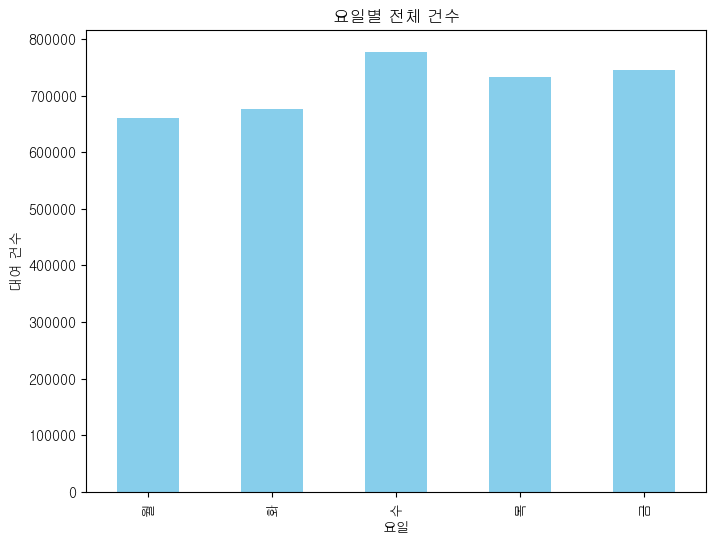

In [21]:

import matplotlib.pyplot as plt
import pandas as pd

강서_데이터['기준_날짜'] = pd.to_datetime(강서_데이터['기준_날짜'], format='%Y-%m-%d')

# 기준_날짜 열에서 요일을 추출하여 새로운 열 추가
강서_데이터['요일'] = 강서_데이터['기준_날짜'].dt.day_name()
# 영어 요일명을 한글 요일명으로 변환하는 사전 생성
영어_한글_요일_매핑 = {
    'Monday': '월',
    'Tuesday': '화',
    'Wednesday': '수',
    'Thursday': '목',
    'Friday': '금',

}

# 요일 순서 정의
요일_순서 = ['월', '화', '수', '목', '금']

# '요일' 열의 값을 한글 요일명으로 변환
강서_데이터['요일'] = 강서_데이터['요일'].map(영어_한글_요일_매핑)

# 요일별 전체 건수 통계 계산
요일별_통계 = 강서_데이터.groupby('요일')['전체_건수'].sum()


# 막대 그래프 그리기
plt.figure(figsize=(8, 6))
요일별_통계[요일_순서].plot(kind='bar', color='skyblue')
plt.title('요일별 전체 건수')
plt.xlabel('요일')
plt.ylabel('대여 건수')
plt.xticks(rotation=90)  # x축 레이블 회전
plt.show()

## 강서구 대여소 쏠림현상 확인

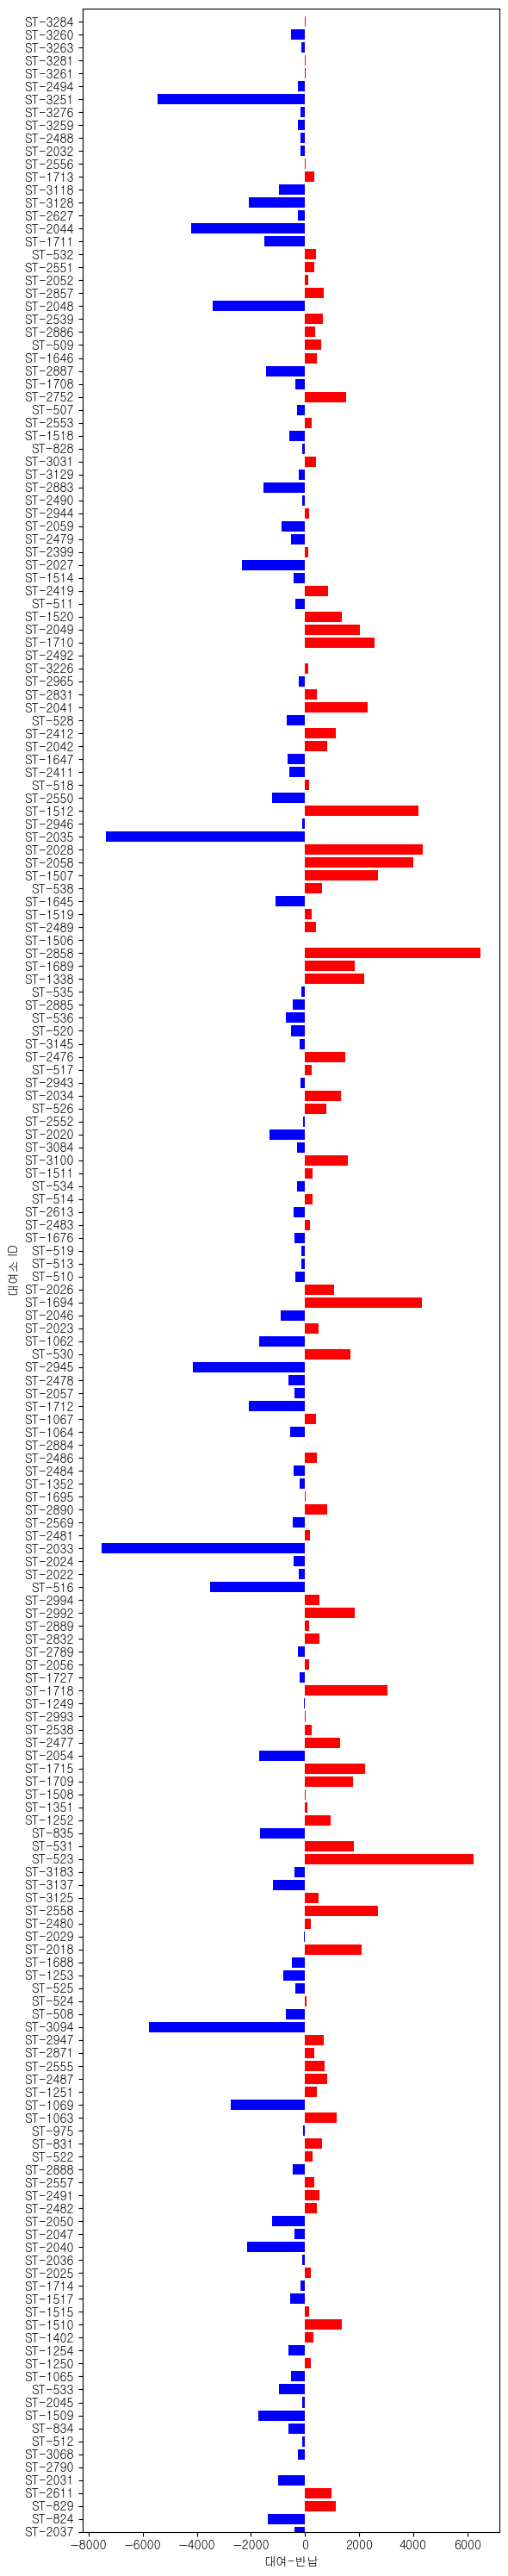

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
# font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
# font = fm.FontProperties(fname=font_path).get_name()
# mpl.rc('font', family=font)

# 강서 대여소 ID 정보 불러옴
강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

# 강서 대여소 이용 현황 정보 불러옴
# 강서_데이터 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')

# 시작 대여소별 전체 횟수 계산(1년 동안 해당 대여소에서 대여한 총량)
시작대여소별_전체횟수 = 강서_데이터.groupby('시작_대여소_ID')['전체_건수'].sum()

# 종료 대여소별 전체 횟수 계산(1년 동안 해당 대여소에서 반납한 총량)
종료대여소별_전체횟수 = 강서_데이터.groupby('종료_대여소_ID')['전체_건수'].sum()

# 강서구에 위치한 대여소 ID 리스트업
len(강서_데이터['시작_대여소_ID'].unique())
# 강서구_대여소_ID_list == '강서구에 위치한 대여소 ID 리스트'로 변수 지정
강서_대여소_ID_list= 강서_데이터['시작_대여소_ID'].unique()

# 대여소 ID를 인덱스로 가지는 시작횟수 리스트 생성
temp_list = []
for i in range(len(강서_대여소_ID_list)):
    temp_list.append(시작대여소별_전체횟수[강서_대여소_ID_list[i]])

# start_count == 대여소 ID를 인덱스로 가지는 시작횟수 리스트로 시리즈 변수 생성
start_count = temp_list.copy()

# 대여소 ID를 인덱스로 가지는 종료횟수 리스트 생성
temp_list2 = []
for i in range(len(강서_대여소_ID_list)):
    temp_list2.append(종료대여소별_전체횟수[강서_대여소_ID_list[i]])

# end_count == 대여소 ID를 인덱스로 가지는 종료횟수 리스트로 시리즈 변수 생성
end_count = temp_list2.copy()

# 강서_대여소_정보 DataFrame 생성
# column = ['대여소_ID', '대여건수', '반납건수']
강서_대여소_정보 = {'대여소_ID' : 강서_대여소_ID_list, '대여건수' : start_count, '반납건수' : end_count}
강서_대여소_정보 = pd.DataFrame(강서_대여소_정보)

# '대여-반납' column 생성 >> 쏠림 현상 유무 확인 기준 지표
강서_대여소_정보['대여-반납'] = 강서_대여소_정보['대여건수'] - 강서_대여소_정보['반납건수']


# '대여-반납'값 : x축 / 대여소_ID : y축 을 가지는 그래프 생성
import matplotlib.font_manager as fm

colors = ['red' if val > 0 else 'blue' for val in 강서_대여소_정보['대여-반납']]
fig, ax = plt.subplots(figsize=(6,30))

plt.barh(강서_대여소_정보['대여소_ID'], 강서_대여소_정보['대여-반납'], color = colors )
# plt.xticks(rotation=90)
plt.ylabel('대여소 ID')
plt.xlabel('대여-반납')
plt.ylim(0, 195)


plt.tight_layout()
plt.show()

# 주거지구,업무지구 산점도

In [36]:
출퇴근_통합정보 = pd.read_csv('../kimseongwon/출퇴근시간_대여소_이용량_통합 - 출퇴근시간_대여소_이용량.csv',encoding='utf-8')
출퇴근_통합정보 = 출퇴근_통합정보.drop('Unnamed: 0', axis=1)
출퇴근_통합정보.rename(columns={'대여소_ID':'대여소_ID',
                               '지구 분류(출근)':'지구분류(출)',
                               '지구 분류(퇴근)':'지구분류(퇴)',
                               '일치여부':'분류일치여부',
                               '강서_데이터_시작(출근)':'시작(출)',
                               '강서_데이터_종료(출근)':'종료(출)',
                               '차이(출근)':'차이(출)',
                               '차이 절대값(출근)':'차이절대값(출)',
                               '총 이용량(시작 + 종료)(출근)':'총이용량(출)',
                               '강서_데이터_시작(퇴근)':'시작(퇴)',
                               '강서_데이터_종료(퇴근)':'종료(퇴)',
                               '차이(퇴근)':'차이(퇴)',
                               '차이절대값(퇴근)':'차이절대값(퇴)',
                               '총 이용량(시작 + 종료)(퇴근)':'총이용량(퇴)'
                               }, inplace=True)

출퇴근_통합정보 = 출퇴근_통합정보.fillna(0)
출퇴근_통합정보[['시작(출)', '종료(출)', '차이(출)', '차이절대값(출)', '총이용량(출)']] = 출퇴근_통합정보[['시작(출)', '종료(출)', '차이(출)', '차이절대값(출)', '총이용량(출)']].astype(int)
출퇴근_통합정보['총이용량(출)'].values.sum()

출퇴근_통합정보['차이절대값합'] = 출퇴근_통합정보['차이절대값(출)'] + 출퇴근_통합정보['차이절대값(퇴)']
출퇴근_통합정보['총이용량합'] = 출퇴근_통합정보['총이용량(출)'] + 출퇴근_통합정보['총이용량(퇴)']

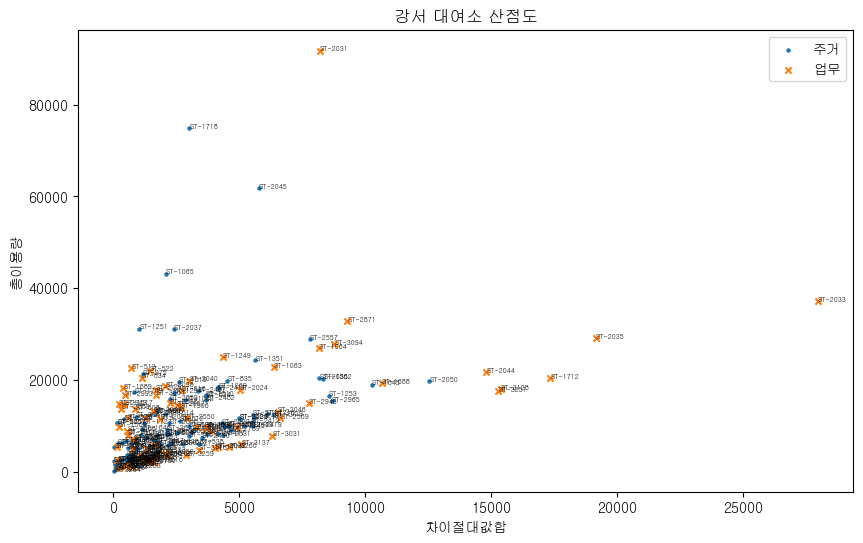

In [37]:
fig, ax = plt.subplots(figsize=(10,6))

출근주거 = 출퇴근_통합정보[출퇴근_통합정보['지구분류(출)'] == '주거']
출근업무 = 출퇴근_통합정보[출퇴근_통합정보['지구분류(출)'] == '업무']

ax.scatter(출근주거['차이절대값합'], 출근주거['총이용량합'], label = '주거', marker='.', s=20)
ax.scatter(출근업무['차이절대값합'], 출근업무['총이용량합'], label = '업무', marker='x', s=20)

for i, txt in enumerate(출퇴근_통합정보['대여소_ID']):
    plt.annotate(txt, (출퇴근_통합정보['차이절대값합'][i], 출퇴근_통합정보['총이용량합'][i]), fontsize=5)

plt.title('강서 대여소 산점도')
plt.xlabel('차이절대값합')
plt.ylabel('총이용량')

plt.legend(loc='best')

plt.show()

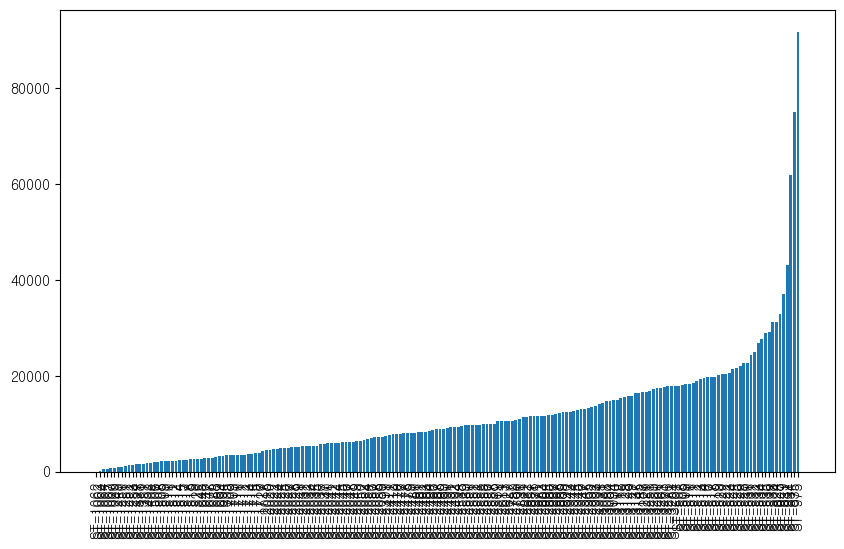

In [38]:
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(출퇴근_통합정보['대여소_ID'], 출퇴근_통합정보.sort_values(by='총이용량합')['총이용량합'])

plt.xticks(rotation=90)
plt.show()

특정 용도지구 / 출퇴근 시간 / 대여, 반납량 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

In [42]:
강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')
강서_따릉이_데이터 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
출퇴근_이용량_통합 = pd.read_csv('../../Data/따릉이/출퇴근_이용량_통합.csv',encoding='utf-8')

In [43]:
강서_따릉이_데이터['기준_날짜'] = pd.to_datetime(강서_따릉이_데이터['기준_날짜'])
강서_따릉이_데이터.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739283 entries, 0 to 1739282
Data columns (total 10 columns):
 #   Column     Dtype         
---  ------     -----         
 0   기준_날짜      datetime64[ns]
 1   기준_시간대     int64         
 2   시작_대여소_ID  object        
 3   종료_대여소_ID  object        
 4   전체_건수      int64         
 5   전체_이용_분    int64         
 6   전체_이용_거리   int64         
 7   요일         int64         
 8   주말         int64         
 9   휴일         int64         
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 132.7+ MB


출근 시간, 퇴근 시간 이용 데이터만 남김
- 데이터 크기가 크고 각 데이터 별로 가진 특성이 너무 다양해서 데이터를 특성 기준에 맞게 분류
- 1차 분류(시간대 분류 >> 전체 시간대에서 출근/ 퇴근 시간대 분류)

In [44]:
출근 = 강서_따릉이_데이터[(강서_따릉이_데이터['기준_시간대'] >= 600) & (강서_따릉이_데이터['기준_시간대'] <= 1000)]
퇴근 = 강서_따릉이_데이터[(강서_따릉이_데이터['기준_시간대'] >= 1700) & (강서_따릉이_데이터['기준_시간대'] <= 2100)]

- 2차 분류(사용 유형[대여 or 반납] >> 출근 시간대의 대여량으로 제한)

In [45]:
# 출근시간 이용량 데이터에서 '기준_날짜', '시작_대여소_ID'로 그룹화 한뒤 전체 건수 합계 추출
# >> 날짜별 대여소별 이용량
출근대여 = 출근.groupby(['기준_날짜', '시작_대여소_ID'])['전체_건수'].sum()

In [46]:
# reset_index()
출근대여= 출근대여.reset_index()

In [47]:
출근대여[:5]

기준_날짜 시작_대여소_ID  전체_건수
0 2023-04-03   ST-1062     32
1 2023-04-03   ST-1063     61
2 2023-04-03   ST-1064     34
3 2023-04-03   ST-1065     57
4 2023-04-03   ST-1067     32

출근시간 일자별 대여소별 대여량 산점도 확인

In [48]:
import plotly.express as px

fig = px.scatter(x = 출근대여['기준_날짜'], y = 출근대여['전체_건수'])

fig.show()

c:\ProgramData\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



출근시간대 일자별 대여소별 상업지구 대여량 
- 3차 분류 (대여소 위치 분류 >> 상업용도 or 주거용도에서 산업 용도로 제한)

In [49]:
# 상업대여소 대여소ID 추출
상업대여소 = 출퇴근_이용량_통합[출퇴근_이용량_통합['최종용도'] == '상업']

In [50]:
# 상업지구출근대여 >> 출근시간대 일자별 대여소별 상업지구 대여량 리스트
상업지구출근대여 = 출근대여[출근대여['시작_대여소_ID'].isin(상업대여소['대여소_ID'])]

In [51]:
상업지구출근대여[:5]

기준_날짜 시작_대여소_ID  전체_건수
1 2023-04-03   ST-1063     61
2 2023-04-03   ST-1064     34
6 2023-04-03   ST-1249     45
7 2023-04-03   ST-1250      4
9 2023-04-03   ST-1252      1

In [52]:
상업지구출근대여.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7002 entries, 1 to 21469
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   기준_날짜      7002 non-null   datetime64[ns]
 1   시작_대여소_ID  7002 non-null   object        
 2   전체_건수      7002 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 218.8+ KB


In [53]:
# 상업지구출근대여의 산점도 확인

import plotly.express as px

fig = px.scatter(x = 상업지구출근대여['기준_날짜'], y = 상업지구출근대여['전체_건수'])

fig.show()

c:\ProgramData\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



상업지구출근대여량 이상치 확인

In [54]:
import plotly.express as px

fig = px.box(data_frame= 상업지구출근대여, y="전체_건수")

fig.show()

# upper fence 54 확인

이상치 max 값으로 대체

In [55]:
# copy
temp_df = 상업지구출근대여.copy()
temp_df

# 이상치 대체
temp_df['전체_건수'] = temp_df['전체_건수'].apply(lambda x: 54 if x > 54 else x)

import plotly.express as px

fig = px.box(data_frame= temp_df, y="전체_건수")

fig.show()

분류 및 이상치 처리를 마친 데이터 셋으로 ARIMA 분석 테스트

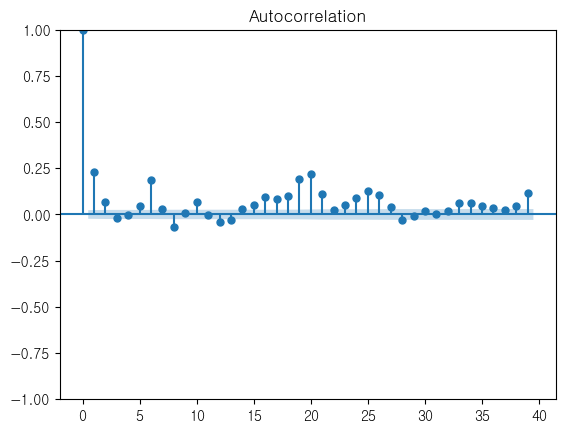

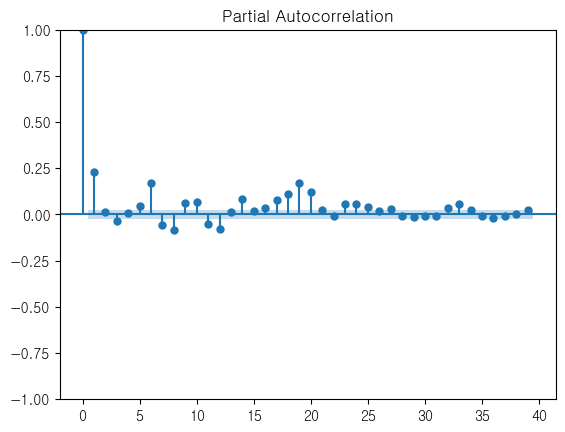

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



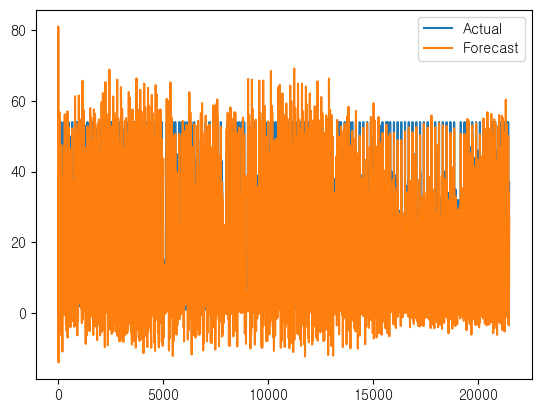

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(temp_df['전체_건수'])
plot_pacf(temp_df['전체_건수'])
plt.show()

model = ARIMA(temp_df['전체_건수'], order=(4, 2, 0))  # p, d, q는 선택한 파라미터입니다.
results = model.fit()

forecast = results.predict(start=0, end=len(temp_df)-1, typ='levels')

plt.plot(temp_df['전체_건수'], label='Actual')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()